# Задача классификации

Задача заключается в классификации результата проверки заведений общественного питания. Ожидается, что алгоритм машинного обучения будет устанавливать, проходит ли проверку (может также проходить с условиями) отдельновзятое заведение при известных нарушениях, типе заведения, типе проверки и прочих признаков.

## Загружаем данные

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

In [2]:
import zipfile

path = "archive.zip"

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall("")

Kaggle, кажется, не предоставляет прямой ссылки на файл данных. Скачиваем, распаковываем и читаем датафрейм с компьютера

In [3]:
# url = "https://www.kaggle.com/tjkyner/chicago-food-inspections?select=Food_Inspections.csv"
data_raw = pd.read_csv("Food_Inspections.csv")

In [4]:
type(data_raw)

pandas.core.frame.DataFrame

This information is derived from inspections of restaurants and other food
establishments in Chicago from January 1, 2010 to the present. Inspections are performed by
staff from the Chicago Department of Public Health’s Food Protection Program. Inspections are
done using a standardized procedure. The results of the inspection are inputted into a database,
then reviewed and approved by a State of Illinois Licensed Environmental Health Practitioner
(LEHP). A subset of data elements are extracted from this database and downloaded into this
data portal

In [5]:
data_raw.shape

(221468, 17)

In [6]:
data_raw.head(5)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2492889,Kozminski,Kozminski,31151.0,School,Risk 1 (High),936 E 54th St (5400S),CHICAGO,IL,60615.0,03/15/2021,Canvass,Pass,NaN,41.798029,-87.602463,"(-87.60246286753599, 41.798029497076946)"
1,2484532,VOLARE,VOLARE,2141813.0,Restaurant,Risk 1 (High),201 E GRAND AVE,CHICAGO,IL,60611.0,02/04/2021,Non-Inspection,No Entry,NaN,41.891652,-87.622604,"(-87.62260381408842, 41.89165221441017)"
2,2472891,MIMI'S TACOS,MIMI'S TACOS,2766681.0,Restaurant,Risk 1 (High),570-572 W ROOSEVELT RD,CHICAGO,IL,60607.0,01/20/2021,License,Not Ready,NaN,41.867330,-87.642117,"(-87.64211742912265, 41.86733048241842)"
3,2472503,WESTERN CAFE,WESTERN CAFE,2487565.0,Restaurant,Risk 1 (High),5710 N WESTERN AVE,CHICAGO,IL,60659.0,01/11/2021,Canvass,Out of Business,NaN,41.985362,-87.689652,"(-87.68965150838075, 41.9853615288893)"
4,2472385,HILLTOP FAMILY RESTAURANT,HILLTOP FAMILY RESTAURANT,2652370.0,Restaurant,Risk 1 (High),2800 W FOSTER AVE,CHICAGO,IL,60625.0,01/07/2021,Non-Inspection,No Entry,NaN,41.975927,-87.699046,"(-87.69904568571212, 41.97592670619184)"


## Определим классы

Рассматривать в качестве классов будем результаты проверки. Посмотрим, какие они бывают.

In [7]:
data_raw['Results'].unique()

array(['Pass', 'No Entry', 'Not Ready', 'Out of Business', 'Fail',
       'Pass w/ Conditions', 'Business Not Located'], dtype=object)

Однако про данные указано, что:
> **Results**: An inspection can pass, pass with conditions or fail. Establishments receiving a
‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15-
29, respectively). Establishments receiving a ‘pass with conditions’ were found to have
critical or serious violations, but these were corrected during the inspection.
Establishments receiving a ‘fail’ were found to have critical or serious violations that
were not correctable during the inspection. An establishment receiving a ‘fail’ does not
necessarily mean the establishment’s licensed is suspended. Establishments found to
be out of business or not located are indicated as such.

Действительно, часть возможных результатов основывается не на имеющихся в датафрейме данных. Таким образом, можно выделить 3 класса, которые можно определить по прочим признакам: *'Pass'*, *'Pass w/ Conditions'*, *'Fail'*. Строки с другими результатами удалим.


In [8]:
data = data_raw[(data_raw['Results'] == "Pass") | (data_raw['Results'] == "Fail") | (data_raw['Results'] == "Pass w/ Conditions")].copy()
data.shape

(192061, 17)

Покажем, что классы не сбалансированы

In [9]:
data['Results'].value_counts(normalize=True)

Pass                  0.601168
Fail                  0.222237
Pass w/ Conditions    0.176595
Name: Results, dtype: float64

In [10]:
data.groupby('Results')['Risk'].value_counts(normalize = True).to_frame()

Risk
Results            Risk                     
Fail               Risk 1 (High)    0.706641
                   Risk 2 (Medium)  0.193127
                   Risk 3 (Low)     0.100115
                   All              0.000117
Pass               Risk 1 (High)    0.738456
                   Risk 2 (Medium)  0.190812
                   Risk 3 (Low)     0.070733
Pass w/ Conditions Risk 1 (High)    0.760651
                   Risk 2 (Medium)  0.192204
                   Risk 3 (Low)     0.047144

### Заменим строковые данные числами

Смотрим, какие значения принимает **Risk**

In [11]:
data['Risk'].unique()

array(['Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)', nan, 'All'],
      dtype=object)

Заменим числовыми значениями

In [12]:
data['Risk'] = data['Risk'].replace(to_replace ='.*(\d).*', value = '\g<1>', regex = True)
#data_raw['Risk'].astype(np.int32)
data['Risk']

0         1
11        1
12        1
15        1
16        1
         ..
221463    1
221464    1
221465    2
221466    2
221467    3
Name: Risk, Length: 192061, dtype: object

И не забудем про *all*. Описание данных ничего не говорит нам о значении *all*. 
> **Risk category of facility:**  Each establishment is categorized as to
> its risk of adversely  
>     affecting the public’s health, with 1 being the highest and 3 the lowest. The frequency of  
>     inspection is tied to this risk, with risk 1 establishments inspected most frequently and  
>     risk 3 least frequently.

Следовательно строки с all не берём

In [13]:
rows_to_drop = data[(data['Risk'] == "All")].index
data = data.drop(rows_to_drop)
data.shape
# rows_to_drop

(192056, 17)

In [14]:
data['Risk'] = data['Risk'].astype('float')

In [15]:
for str in ['Facility Type', 'Inspection Type', 'Results']:
    data[str] = data[str].astype('category')

In [16]:
data.describe()

,Inspection ID,License #,Risk,Zip,Latitude,Longitude
count,1.920560e+05,1.920400e+05,192022.000000,192024.000000,191353.000000,191353.000000
mean,1.533368e+06,1.628621e+06,1.337769,60628.618667,41.880396,-87.676203
std,6.847017e+05,9.128008e+05,0.608173,123.355297,0.081130,0.059248
min,4.424700e+04,0.000000e+00,1.000000,10014.000000,41.644670,-87.914428
25%,1.166310e+06,1.228416e+06,1.000000,60614.000000,41.831075,-87.707109
50%,1.537356e+06,1.999098e+06,1.000000,60625.000000,41.891279,-87.665571
75%,2.135944e+06,2.283206e+06,2.000000,60643.000000,41.939654,-87.634531
max,2.521547e+06,9.999999e+06,3.000000,60827.000000,42.021064,-87.525094


## Пропущенные значения

In [17]:
data.isna().sum()

Inspection ID          0
DBA Name               0
AKA Name            1736
License #             16
Facility Type        645
Risk                  34
Address                0
City                 125
State                 45
Zip                   32
Inspection Date        0
Inspection Type        1
Results                0
Violations         30494
Latitude             703
Longitude            703
Location             703
dtype: int64

Отсутствующих значений для *Facility Type* и *Inspection Type* не так много относительно общего количества строк. Кроме того, отсутствие номера лицензии не внушает доверия результату проверки. Просто удалим соответствующие строки.

In [18]:
rows_to_drop = data[(data['Facility Type'].isna()) | (data['Inspection Type'].isna()) | (data['License #'].isna())].index
data = data.drop(rows_to_drop)
data.shape

(191394, 17)

Глянем *Violations*. Пустые значения должны как правило означать отсутствие нарушений и пусты не по ошибке, поэтому удалять строки мы не будем.

In [19]:
data.at[221463, 'Violations']

'34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: The floors shall be constructed per code, be smooth and easily cleaned, and be kept clean and in good repair.    FLOORS IN NEED OF CLEANING TO REMOVE BUILD-UP. MUST CLEAN AND MAINTAIN. | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: The walls and ceilings shall be in good repair and easily cleaned. Use dustless cleaning methods.    WALLS AND CEILINGS IN NEED OF CLEANING TO REMOVE FOOD AND DUST. MUST CLEAN AND MAINTAIN. | 38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED - Comments: The flow of air discharged from kitchen fans shall always be through a duct to a point above the roofline. Ventilation: All plumbing fixtures, such as toilets, sinks, washbasins, etc., must be adequately trapped, vented, and re-vented and properly connected to the 

In [20]:
text = data.at[221463, 'Violations']
import re
regex_num = re.compile('\d+\.')  
regex_num.findall(text)  

['34.', '35.', '38.']

Попробуем разобрать эти значения. Добавим столбцы с номерами возможных нарушений.

> **Violations**: An establishment can receive one or more of 45 distinct violations (violation
numbers 1-44 and 70). For each violation number listed for a given establishment, the
requirement the establishment must meet in order for it to NOT receive a violation is
noted, followed by a specific description of the findings that caused the violation to be
issued.

In [21]:
regex_num = re.compile('(?:(?<=^)|(?<=\| ))\d+\.') 
for i, row in data.iterrows():    
    violations = regex_num.findall(f"{row['Violations']}") 
    #print(violations)
    
    for violation in violations:
        data.at[i, violation] = 1
    

In [22]:
data.at[15, 'Violations']

'3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: SEE VIOLATION #60.  | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: MUST PROVIDE HAND WASHING SIGNAGE AT ALL WASHBOWL AND HAND WASHING SINKS.\t | 16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED - Comments: OBSERVED EXCESSIVE AMOUNT OF BLACK AND BROWN, SLIMY, MOLD-LIKE SUBSTANCES THROUGHOUT INTERIOR OF ICE MACHINE, AND COMING IN CONTACT WITH ICE. MUST REMOVE SUBSTANCE, DETAIL CLEAN AND SANITIZE MACHINE. PRIORITY FOUNDATION VIOLATION 7-38-005. CITATION ISSUED.  | 35. APPROVED THAWING METHODS USED - Comments: OBSERVED IMPROPER THAWING METHOD IN USE. OBSERVED FISH AND CRAB SITTING IN STANDING WATER IN 3 COMPARTMENT SINK. (CRAB @ 38.8F AND FISH @ 41F)INSTRUCTED MUST USE ONE OF THE FOLLOWING APPROVED METHOD FOR THAWING: IN REFRIGERATION, IN A MICROWAVE AS PART OF A CONTINUOUS COOKING PROCESS, OR COMPLETELY SUBMERGED UNDER RUNNING WATER WITH SUFFICIENT WAT

In [23]:
data['3.']

0         NaN
11        NaN
12        NaN
15        1.0
16        NaN
         ... 
221463    NaN
221464    NaN
221465    NaN
221466    NaN
221467    NaN
Name: 3., Length: 191394, dtype: float64

In [24]:
data.iloc[:, 17:] = data.iloc[:, 17:].fillna(0, axis = 0)
data.iloc[:, 16:]

,Location,3.,10.,16.,35.,36.,37.,47.,53.,55.,...,24.,13.,7.,26.,42.,4.,17.,70.,27.,63.
0,"(-87.60246286753599, 41.798029497076946)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,"(-87.72392832288558, 41.81310105112748)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,"(-87.61192836248603, 41.802049821529806)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,"(-87.74586369218258, 41.91399920930635)",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,"(-87.64299618172501, 41.896585191199556)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221463,"(-87.62602037433696, 41.8974381950521)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221464,"(-87.59902191495524, 41.655906736353224)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221465,"(-87.62517250873418, 41.883115221384855)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221466,"(-87.83684032683502, 41.9627679194481)",0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
data['3.']

0         0.0
11        0.0
12        0.0
15        1.0
16        0.0
         ... 
221463    0.0
221464    0.0
221465    0.0
221466    0.0
221467    0.0
Name: 3., Length: 191394, dtype: float64

Столбец *Violations* можно теперь удалить. Вместе с ним и Location. Так как координаты уже записаны в отдельных столбцах.

In [26]:
data = data.drop('Violations', axis = 1)

In [27]:
data = data.drop('Location', axis = 1)

Пропущенные значения *AKA Name* скопируем с *DBA Name*

In [28]:
data['AKA Name'] = data['AKA Name'].fillna(data['DBA Name'])

In [29]:
data.iloc[:, :15].isna().sum()

Inspection ID        0
DBA Name             0
AKA Name             0
License #            0
Facility Type        0
Risk                15
Address              0
City               122
State               45
Zip                 31
Inspection Date      0
Inspection Type      0
Results              0
Latitude           698
Longitude          698
dtype: int64

Убедимся, что мы не переименовали по ошибке все строки, и заодно убедимся, что есть заведения, у которых отличаются официальное и общеизвестное название.

In [30]:
data[(data['DBA Name'] != data['AKA Name'])]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,24.,13.,7.,26.,42.,4.,17.,70.,27.,63.
40,2382667,STARBUCKS COFFEE # 216,STARBUCKS COFFEE,2398564.0,Restaurant,2.0,401 E ONTARIO ST,CHICAGO,IL,60611.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,2382213,WINGSTOP RESTAURANT,WINGSTOP,2570340.0,Restaurant,2.0,6024-6026 N BROADWAY AVE,CHICAGO,IL,60660.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2374199,CHOCOLATE CITY,DARK MATTER,2658208.0,Restaurant,2.0,2015 W GRAND AVE,CHICAGO,IL,60612.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,2373373,UPTON'S NATURALS CO.,UPTON'S,2277659.0,Restaurant,1.0,2054 W GRAND AVE,CHICAGO,IL,60612.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,2369855,Chicago Prep Master Tenant LLC,Chicago Prep Master Tenant,2723671.0,Shared Kitchen,1.0,5801 W Dickens AVE,CHICAGO,IL,60639.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221458,229220,Eurest Dining Services @ Credit Suisse Chicago,Credit Suisse Cafe,1488775.0,Restaurant,1.0,227 W MONROE ST,CHICAGO,IL,60606.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221459,60390,MARISCOS BAHIA,"ELIAS TACOS, INCORPORATED",1488236.0,Restaurant,1.0,4465 S ARCHER AVE,CHICAGO,IL,60632.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221461,158244,"PARK PACKING OF CHICAGO, INC",PARK PACKING,2008956.0,Wholesale,2.0,1544 W 41ST ST,CHICAGO,IL,60609.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221462,72270,CHOP TOUHY,MAIN PIZZA CHALAVI,2021764.0,Restaurant,1.0,2931 W TOUHY AVE,CHICAGO,IL,60645.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Какой-либо анализ строк  названий провести сложно, но мы можем ввести дополнительный признак соответствия *DBA Name* и *AKA Name*

In [31]:
data['One name'] =  data['DBA Name'] == data['AKA Name']
data['One name'] = data['One name'].astype(int)
data['One name']

0         1
11        1
12        1
15        1
16        1
         ..
221463    1
221464    1
221465    0
221466    1
221467    1
Name: One name, Length: 191394, dtype: int32

Пропущенные значения в столбцах *City, State, Zip* заполним модой:

In [32]:
data['City'].fillna(data['City'].mode().iloc[0], inplace=True)
data['State'].fillna(data['State'].mode().iloc[0], inplace=True)
data['Zip'].fillna(data['Zip'].mode().iloc[0], inplace=True)

Пропущенные значения *Risk, Latitude, Longitude* заменим медианой.           

In [33]:
for col in ['Risk', 'Latitude', 'Longitude']:
    data[col].fillna(data[col].median(axis = 0), inplace=True)

In [34]:
data.iloc[:, :15].isna().sum()

Inspection ID      0
DBA Name           0
AKA Name           0
License #          0
Facility Type      0
Risk               0
Address            0
City               0
State              0
Zip                0
Inspection Date    0
Inspection Type    0
Results            0
Latitude           0
Longitude          0
dtype: int64

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191394 entries, 0 to 221467
Data columns (total 81 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Inspection ID    191394 non-null  int64   
 1   DBA Name         191394 non-null  object  
 2   AKA Name         191394 non-null  object  
 3   License #        191394 non-null  float64 
 4   Facility Type    191394 non-null  category
 5   Risk             191394 non-null  float64 
 6   Address          191394 non-null  object  
 7   City             191394 non-null  object  
 8   State            191394 non-null  object  
 9   Zip              191394 non-null  float64 
 10  Inspection Date  191394 non-null  object  
 11  Inspection Type  191394 non-null  category
 12  Results          191394 non-null  category
 13  Latitude         191394 non-null  float64 
 14  Longitude        191394 non-null  float64 
 15  3.               191394 non-null  float64 
 16  10.              191

Сократим количество ошибочных категорий

In [36]:
data.describe(include=['category'])

,Facility Type,Inspection Type,Results
count,191394,191394,191394
unique,487,104,3
top,Restaurant,Canvass,Pass
freq,129306,93076,115205


In [37]:
data['Facility Type'].unique()

['School', 'Restaurant', 'Children's Services Facility', 'Grocery Store', 'Shared Kitchen', ..., 'Candy', 'TAVERN/LIQUOR', 'incubator', 'WHOLESALE BAKERY', 'Kids Cafe'']
Length: 487
Categories (487, object): ['School', 'Restaurant', 'Children's Services Facility', 'Grocery Store', ..., 'TAVERN/LIQUOR', 'incubator', 'WHOLESALE BAKERY', 'Kids Cafe'']

In [38]:
data['Facility Type'] = data['Facility Type'].str.lower().astype('category')
data['Inspection Type'] = data['Inspection Type'].str.lower().astype('category')

In [39]:
data.describe(include=['category'])

,Facility Type,Inspection Type,Results
count,191394,191394,191394
unique,437,93,3
top,restaurant,canvass,Pass
freq,129306,93076,115205


Категорий всё ещё много. Многие из них возникли из-за опечаток. Оставим только те, к которым принадлежит не менее двадцати строк.

In [40]:
facility_counts = data['Facility Type'].value_counts()
inspection_counts = data['Inspection Type'].value_counts()
rows_to_drop = data[data['Facility Type'].isin(facility_counts[facility_counts < 20].index)].index
data = data.drop(rows_to_drop)
rows_to_drop = data[data['Inspection Type'].isin(inspection_counts[inspection_counts < 5].index)].index
data = data.drop(rows_to_drop)

In [41]:
data.describe(include=['category'])

,Facility Type,Inspection Type,Results
count,189615,189615,189615
unique,67,26,3
top,restaurant,canvass,Pass
freq,129269,92374,114170


## Визуализация

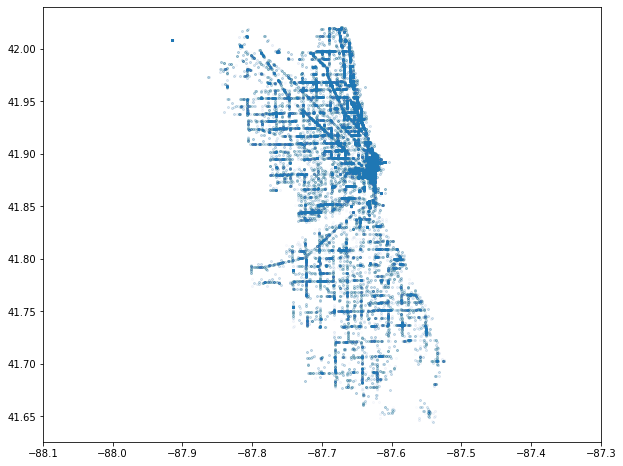

In [42]:
plt.figure(figsize = (10, 8))
plt.scatter(data['Longitude'], data['Latitude'], alpha=0.01, s = 5)
plt.xlim([-88.1, -87.3])
pass

Местоположение объектов проверки соответствует действительности. Все они находятся в Чикаго.

![изображение Чикаго на карте](chicago.png "Чикаго на карте")

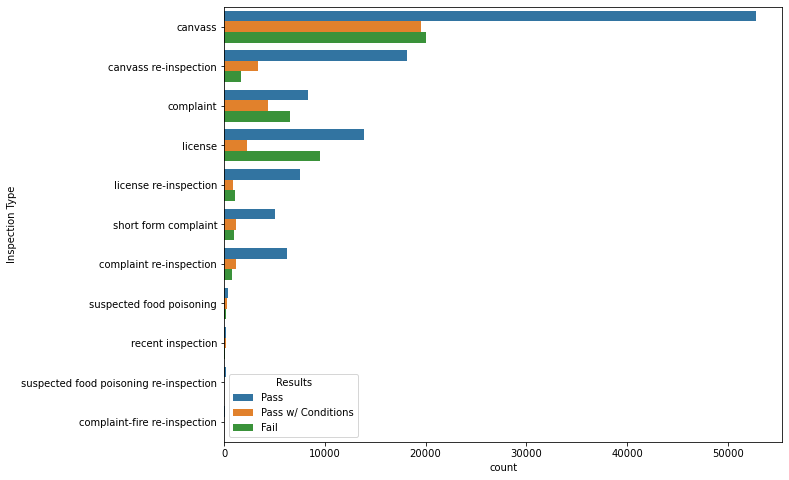

In [43]:
plt.figure(figsize = (10, 8))

sns.countplot(y='Inspection Type', order=data['Inspection Type'].unique()[0:11], hue='Results', hue_order=['Pass', 'Pass w/ Conditions', 'Fail'], data=data)
pass

При повторном опросе доля *Pass* больше. Тип проверки *license* имеет самое большое соотношение результатов *Fail* к *Pass*.

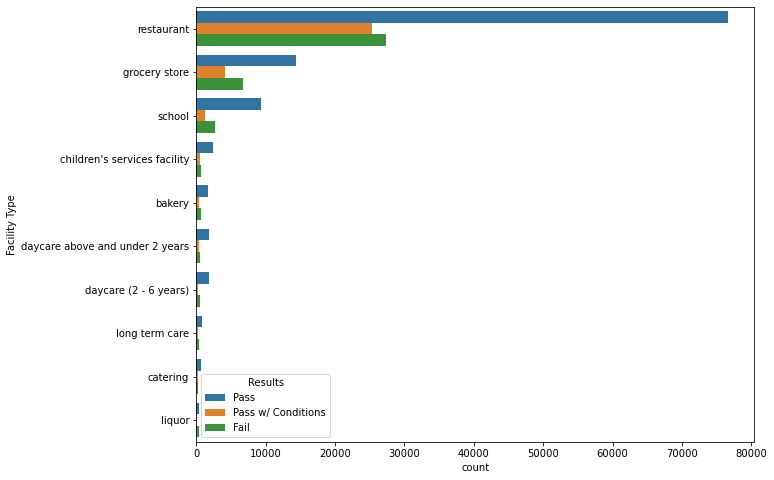

In [44]:
plt.figure(figsize = (10, 8))

sns.countplot(y='Facility Type', order=data['Facility Type'].value_counts().index[0:10], hue='Results', hue_order=['Pass', 'Pass w/ Conditions', 'Fail'], data=data)
pass

Все заведения чаще не проходят проверку, чем проходят с условием.

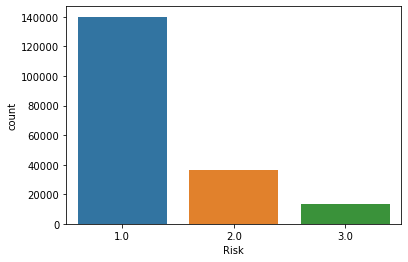

In [45]:
sns.countplot(x='Risk', data=data)
pass

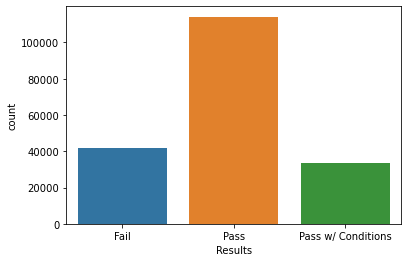

In [46]:
sns.countplot(x='Results', data=data)
pass

In [47]:
data.groupby('Results')['Risk'].value_counts(normalize = True).to_frame()

Risk
Results            Risk          
Fail               1.0   0.712439
                   2.0   0.191827
                   3.0   0.095734
Pass               1.0   0.741281
                   2.0   0.190111
                   3.0   0.068608
Pass w/ Conditions 1.0   0.763631
                   2.0   0.191042
                   3.0   0.045327

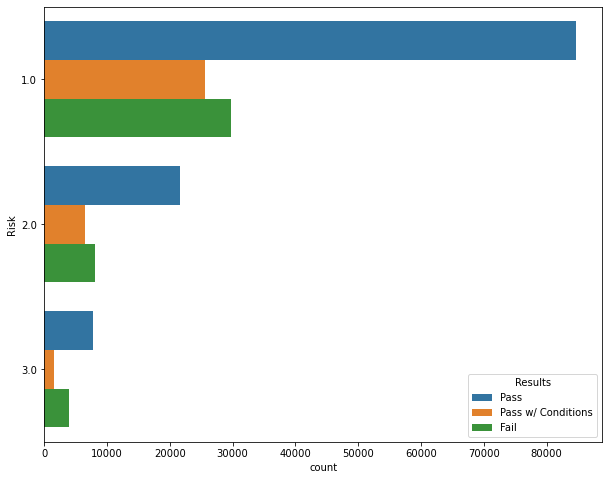

In [48]:
plt.figure(figsize = (10, 8))

sns.countplot(y='Risk', order=data['Risk'].value_counts().index, hue='Results', hue_order=['Pass', 'Pass w/ Conditions', 'Fail'], data=data)
pass

Относительно каждого результата риски распределяются примерно схожим образом. *Pass w/ Conditions* с минимальным уровнем риска встречается заметно реже других результатов.

<AxesSubplot:ylabel='Results-Risk'>

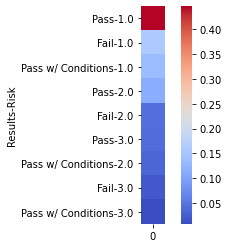

In [49]:
rr_mat = data.loc[:, ['Results', 'Risk']].value_counts(normalize = True).to_frame()
sns.heatmap(rr_mat, square=True, cmap='coolwarm')

Самая популярная пара значений – **Pass, Risk 1 (High)**

In [50]:
rr_mat

,,0
Results,Risk,
Pass,1.0,0.446336
Fail,1.0,0.157224
Pass w/ Conditions,1.0,0.135316
Pass,2.0,0.114469
Fail,2.0,0.042333
Pass,3.0,0.041310
Pass w/ Conditions,2.0,0.033853
Fail,3.0,0.021127
Pass w/ Conditions,3.0,0.008032


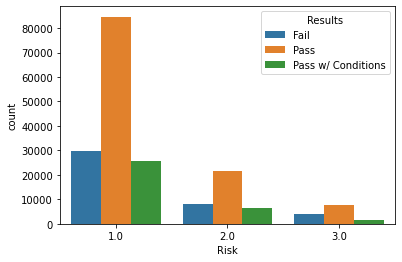

In [51]:
sns.countplot(x='Risk', order=data['Risk'].value_counts().index, hue='Results', data=data)
pass

In [52]:
data.describe()

,Inspection ID,License #,Risk,Zip,Latitude,Longitude,3.,10.,16.,35.,...,13.,7.,26.,42.,4.,17.,70.,27.,63.,One name
count,1.896150e+05,1.896150e+05,189615.000000,189615.000000,189615.000000,189615.000000,189615.000000,189615.000000,189615.000000,189615.000000,...,189615.000000,189615.000000,189615.000000,189615.000000,189615.000000,189615.000000,189615.000000,189615.000000,189615.000000,189615.000000
mean,1.537623e+06,1.628240e+06,1.331593,60628.943201,41.880461,-87.676218,0.121246,0.050170,0.040039,0.333608,...,0.003739,0.000791,0.007462,0.033615,0.002753,0.000781,0.002869,0.002067,0.000105,0.740485
std,6.819335e+05,9.131641e+05,0.602145,43.396179,0.081018,0.059138,0.326413,0.218296,0.196051,0.471503,...,0.061034,0.028115,0.086063,0.180238,0.052396,0.027927,0.053486,0.045421,0.010270,0.438370
min,4.424700e+04,0.000000e+00,1.000000,46319.000000,41.644670,-87.914428,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.174384e+06,1.228221e+06,1.000000,60614.000000,41.831192,-87.706935,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.537753e+06,1.999082e+06,1.000000,60625.000000,41.891265,-87.665567,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.136116e+06,2.283310e+06,2.000000,60643.000000,41.939473,-87.634599,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.521547e+06,8.700606e+06,3.000000,60827.000000,42.021064,-87.525094,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
corr_mat = data.corr()
corr_mat

,Inspection ID,License #,Risk,Zip,Latitude,Longitude,3.,10.,16.,35.,...,13.,7.,26.,42.,4.,17.,70.,27.,63.,One name
Inspection ID,1.000000,0.244347,-0.076719,0.001698,0.047474,-0.009639,0.224459,0.234561,0.070749,-0.234148,...,-0.011788,0.002451,-0.040427,-0.049440,-0.052639,0.005790,-0.031889,-0.018003,0.011699,-0.045426
License #,0.244347,1.000000,0.079255,-0.012222,0.001744,0.037257,0.066873,0.034441,0.006716,-0.156320,...,-0.016071,-0.002476,-0.033117,-0.010009,-0.022432,0.003352,-0.002788,-0.015586,0.004692,-0.049009
Risk,-0.076719,0.079255,1.000000,-0.017326,-0.095899,-0.006002,-0.064380,-0.011693,-0.038083,-0.055608,...,0.006730,-0.002099,0.012598,-0.032537,-0.011048,-0.006296,0.020078,0.005402,-0.003097,-0.002037
Zip,0.001698,-0.012222,-0.017326,1.000000,0.076372,-0.172596,0.002781,0.000281,0.001467,0.011306,...,0.002515,-0.001498,-0.001047,-0.007995,-0.000342,-0.001330,0.003660,0.002845,-0.000448,-0.026459
Latitude,0.047474,0.001744,-0.095899,0.076372,1.000000,-0.424004,0.024511,-0.005949,0.055883,-0.047773,...,-0.003307,0.003378,-0.036773,0.020208,0.021835,-0.003660,0.004880,-0.018101,-0.001990,-0.126683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17.,0.005790,0.003352,-0.006296,-0.001330,-0.003660,0.002100,0.016810,0.000497,0.016447,0.009062,...,0.001382,0.005930,0.001965,0.014695,0.005740,1.000000,0.012624,0.002886,-0.000287,0.002330
70.,-0.031889,-0.002788,0.020078,0.003660,0.004880,-0.000077,-0.001196,-0.004197,0.012684,0.041933,...,0.027409,-0.001509,0.003369,0.006955,0.025410,0.012624,1.000000,0.030121,-0.000551,-0.000185
27.,-0.018003,-0.015586,0.005402,0.002845,-0.018101,0.002110,-0.006591,-0.009397,0.003734,0.025420,...,0.010528,0.011109,0.037877,0.003107,-0.000175,0.002886,0.030121,1.000000,-0.000467,0.004696
63.,0.011699,0.004692,-0.003097,-0.000448,-0.001990,0.002074,0.010344,0.004697,0.003141,-0.007267,...,-0.000629,-0.000289,-0.000891,-0.001916,-0.000540,-0.000287,-0.000551,-0.000467,1.000000,0.000223


Посмотрим более-менее значимые корреляции

In [54]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

3.   5.     0.571411
55.  49.    0.509995
58.  5.     0.508970
dtype: float64

Значит, некоторые пары нарушений совместно встречаются чаще

In [55]:
corr_mat.where(np.triu(corr_mat < -0.3, k=1)).stack().sort_values(ascending=False)

Latitude  Longitude   -0.424004
dtype: float64

Вероятно, долгота убывает при росте широты, поскольку город ориентирован не строго с севера на юг, а слегка на юго-восток.

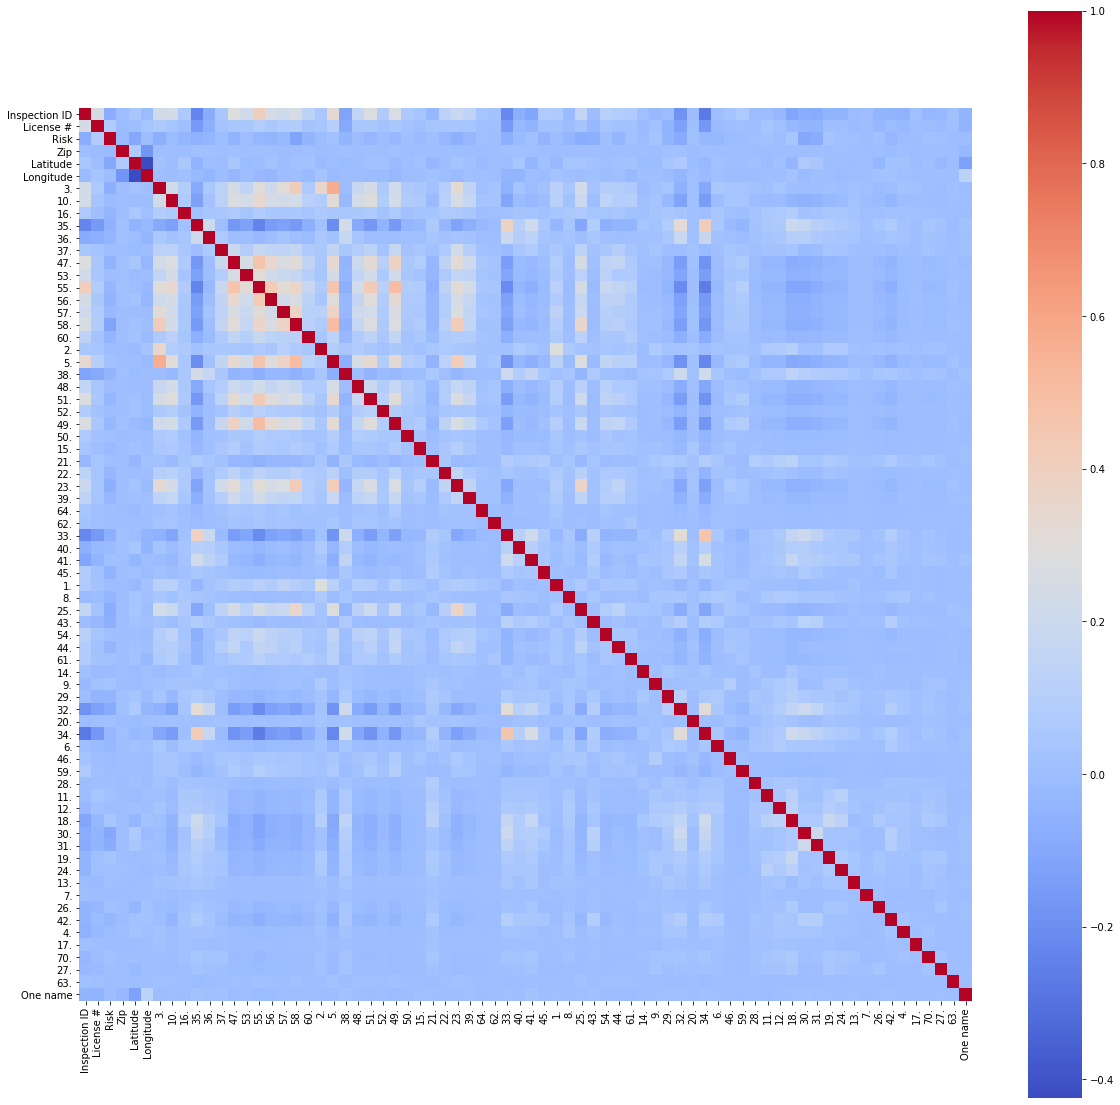

In [56]:
plt.figure(figsize = (20, 20))
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

## Окончательная подготовка данных

In [57]:
data['Inspection Date'] = pd.to_datetime(data['Inspection Date']).astype(np.int64)
data['Inspection Date']

0         1615766400000000000
11        1606435200000000000
12        1604534400000000000
15        1603324800000000000
16        1603152000000000000
                 ...         
221462    1268092800000000000
221464    1266537600000000000
221465    1263254400000000000
221466    1268179200000000000
221467    1264982400000000000
Name: Inspection Date, Length: 189615, dtype: int64

In [58]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['DBA Name', 'AKA Name', 'Address', 'City', 'State']
['Inspection ID', 'License #', 'Facility Type', 'Risk', 'Zip', 'Inspection Date', 'Inspection Type', 'Results', 'Latitude', 'Longitude', '3.', '10.', '16.', '35.', '36.', '37.', '47.', '53.', '55.', '56.', '57.', '58.', '60.', '2.', '5.', '38.', '48.', '51.', '52.', '49.', '50.', '15.', '21.', '22.', '23.', '39.', '64.', '62.', '33.', '40.', '41.', '45.', '1.', '8.', '25.', '43.', '54.', '44.', '61.', '14.', '9.', '29.', '32.', '20.', '34.', '6.', '46.', '59.', '28.', '11.', '12.', '18.', '30.', '31.', '19.', '24.', '13.', '7.', '26.', '42.', '4.', '17.', '70.', '27.', '63.', 'One name']


In [60]:
for c in categorical_columns:
    print(c, data[c].unique())

DBA Name ['Kozminski' 'SUBWAY' 'DYETT HIGH SCHOOL' ... 'A1 GROCERY'
 'COUSCOUS HOUSE' 'RIB PALACE']
AKA Name ['Kozminski' 'SUBWAY' 'DYETT HIGH SCHOOL' ... 'A1 GROCERY'
 'COUSCOUS HOUSE' 'COOKTEK PASTRY #1']
Address ['936 E 54th St (5400S) ' '4406 S PULASKI RD ' '555 E 51st St(5100S) ' ...
 '2301 N Clark ST ' '1800 E 79TH ST BLDG ' '375 E 75TH ST ']
City ['CHICAGO' 'NILES NILES' 'OAK PARK' 'Chicago' 'MAYWOOD' 'SCHAUMBURG'
 'CALUMET CITY' 'BLOOMINGDALE' 'CICERO' 'chicago' 'SKOKIE' 'EVANSTON'
 'BOLINGBROOK' 'LAKE ZURICH' 'WORTH' 'CHARLES A HAYES' 'ALSIP' 'CCHICAGO'
 'CHicago' 'CHICAGOC' 'MORTON GROVE' '312CHICAGO' 'CHICAGOHICAGO'
 'CHICAGOCHICAGO' 'BRIDGEVIEW' 'NEW HOLSTEIN' 'GRIFFITH' 'ELMHURST'
 'CHICAGO.' 'ALGONQUIN' 'LANSING' 'WHEATON' 'WADSWORTH' 'ROSEMONT'
 'PLAINFIELD' 'PALOS PARK' 'HIGHLAND PARK' 'ELK GROVE VILLAGE'
 'LAKE BLUFF' 'SCHILLER PARK' 'Norridge' 'CHCHICAGO' 'COUNTRY CLUB HILLS'
 'CHICAGO HEIGHTS' 'JUSTICE' 'SUMMIT' 'TINLEY PARK' 'EAST HAZEL CREST'
 'LOMBARD' 'DES PLAINE

Мы видели, что все точки находятся в пределах Чикаго. Поэтому столбцы *City*, *Address* и *State* проигнорируем. Собственно названия тоже не представляют какого-то интереса. Удалим все эти столбцы

In [61]:
for c in categorical_columns:
    data = data.drop(c, axis=1)

In [62]:
dummies = pd.get_dummies(data[['Facility Type', 'Inspection Type']])

In [63]:
dummies.head()

,Facility Type_(convenience store),Facility Type_(gas station),Facility Type_1005 nursing home,Facility Type_1023,Facility Type_1023 childern's service facility,Facility Type_1023 childern's service s facility,Facility Type_1023 childern's services facility,Facility Type_1023 children's services facility,Facility Type_1023-children's services facility,Facility Type_1475 liquor,...,Inspection Type_task force liquor inspection 1474,Inspection Type_task force night,Inspection Type_task force not ready,Inspection Type_task force package goods 1474,Inspection Type_task force package liquor,Inspection Type_task force(1470) liquor tavern,Inspection Type_taskforce,Inspection Type_taste of chicago,Inspection Type_tavern 1470,Inspection Type_two people ate and got sick.
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
data = pd.concat((data, dummies), axis=1)
data = data.drop(['Facility Type'], axis=1).drop(['Inspection Type'], axis=1)


In [65]:
data.shape

(189615, 604)

Количественных признаков практически нет в таком большом датафрейме. Те, что есть, не столь сильно влияют на результат по смыслу задачи. Поэтому нормализовывать их не будем.

# X и y

In [66]:
from sklearn.model_selection import train_test_split

X = data.drop('Results', axis = 1).values
y = data['Results'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

In [67]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(170653, 603) (18962, 603)
(170653,) (18962,)


## Классификатор ближайших соседей

In [68]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
#knn.set_params(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [69]:
err_test = 1 - knn.score(X_test, y_test) # Другой способ

Доля ошибочных классификаций на тестовой выборке

In [70]:
err_test

0.40275287416939143

In [71]:
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(X_train, y_train)
err_test = 1 - knn.score(X_test, y_test)
err_test

0.37786098512815103

In [72]:
knn = KNeighborsClassifier(n_neighbors = 40)
knn.fit(X_train, y_train)
err_test = 1 - knn.score(X_test, y_test)
err_test

0.369317582533488

In [73]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
err_test = 1 - knn.score(X_test, y_test)
err_test

0.4406180782617868

In [74]:
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train, y_train)
err_test = 1 - knn.score(X_test, y_test)
err_test

0.3657841999789052

In [75]:
knn = KNeighborsClassifier(n_neighbors = 1000)
knn.fit(X_train, y_train)
err_test = 1 - knn.score(X_test, y_test)
err_test

0.3649404071300496

Доля ошибочных классификаций на учебной выборке

In [76]:
knn = KNeighborsClassifier(n_neighbors = 1000)
knn.fit(X_train, y_train)
err_train = 1 - knn.score(X_train, y_train)
err_train

0.3632986235225868

Код с использованием GridSearchCV не закончил работу за 12 часов, поэтому решено было поустанвливать количество соседей вручную. При увеличении n_neighbors уменьшается доля ошибки, но скорость этого уменьшения экспоненциально падает. Далее увеличивать количество соседей не вижу смысла. Большая ошибка обусловлена малым количеством разнородных признаков, большим количеством опечаток и вольности в написании одинаковых типов. Возможно, также повлияли отсутствующие нарушения в тех проверках, где нарушения в реальности были. Допускаю, что нормализация может улучшить результаты.

Для большей точности нужно перебирать варианты: с нормализацией/без, со всеми исходными типами/с исправленными и сокращёнными до минимальных количеств, со всеми пустыми Violations/без пустых Violations для непрошедших проверку.